# Определение стоимости автомобилей

Задача проекта:

Построить модель для определения рыночной стоимости автомобилей с пробегом по историческим данным (технические характеристики, комплектации и цены автомобилей).

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
- Загрузка библиотек;
- Открытие файлов и изучение данных;
- Предобработка данных;
- Кодирование категориальных признаков;
- Разделение на выборки;
- Обучение моделей линейной регрессии, CatBoostRegressor, LightGBM;
- Анализ и сравнение моделей, формулирование общего вывода.

## Подготовка данных

### Загрузка библиотек

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder

### Открытие файла

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Описание данных
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

### Изучение данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете 16 столбцов и 354369 строк, типы данных: int64 и object.

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Минимальное и максимальное значение в столбце `RegistrationYear` (год регистрации автомобиля) - 1000 и 9999. Возможно являются ошибками в данных и выбросами. 

Cтолбец `NumberOfPictures` содержит только нули, его можно удалить.

Cтолбец `Power` содержит неадекватные данные (более 2700 л.с. в реальности не встречается).

In [5]:
data.duplicated().sum()

4

В данных присутствует 4 дубликата.

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В столбцах `VehicleType, Gearbox, Model, FuelType, NotRepaired` присутствуют пропуски.

In [7]:
data.isna().sum()/data.shape[0]

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Для столбца `NotRepaired` (была машина в ремонте или нет) доля пропусков составляет более 20%.

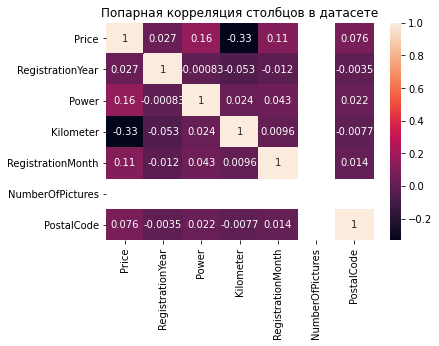

In [8]:
seaborn.heatmap(data.corr(), annot=True)
plt.title('Попарная корреляция столбцов в датасете');

Высоких значений положительной или отрицательной корреляции не обнаружено.

In [9]:
datecrawled = pd.to_datetime(data['DateCrawled'])
datecrawled.max()

Timestamp('2016-04-07 14:36:58')

Последняя дата скачивания анкеты - 7 апреля 2016, это значит, что более поздние данные о годе регистрации некорректны. 

### Предобработка данных

Cтолбцы `DateCrawled, DateCreated, LastSeen, NumberOfPictures, PostalCode, RegistrationMonth` никак не повлияют на обучение модели. Удаляем их.

In [10]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis=1)

Удаляем дубликаты

In [11]:
data.duplicated().sum()

45040

In [12]:
data.duplicated().sum()/data.shape[0]

0.1270991537070116

После удаления неинформативных для нашей задачи столбцов количество дубликатов увеличилось с 4 до 45040, что является 12.7% данных.

In [13]:
data = data.drop_duplicates().reset_index(drop=True)

Удаляем строки, где `Price` равно 0.

In [14]:
data = data.query('Price > 0')

В столбцах `VehicleType, Gearbox, Model, FuelType, NotRepaired`, где присутствуют пропуски, заменим их на unknown. При кодировании этих признаков появится дополнительная категория.

In [15]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = data[[
    'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].fillna('unknown')

In [16]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

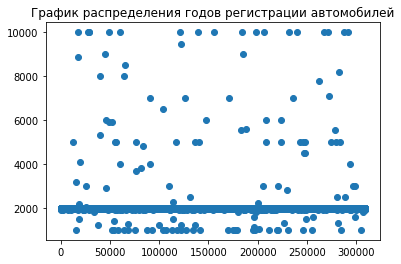

In [17]:
data['RegistrationYear'].plot(style='o', title='График распределения годов регистрации автомобилей');

В столбце `RegistrationYear` большое количество выбросов. Чтобы сделать данные чище, оставим только информацию с 1920 по 2020 гг.

In [18]:
data = data.query('RegistrationYear > 1920 & RegistrationYear < 2016')

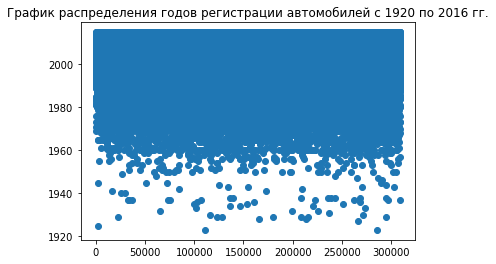

In [19]:
data['RegistrationYear'].plot(style='o', title='График распределения годов регистрации автомобилей c 1920 по 2016 гг.');

Cтолбец `Power` содержит неадекватные данные (более 2700 л.с. в реальности не встречается). Удалим строки с данными сверх нормы.

In [20]:
data = data.query('Power < 2700')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278866 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             278866 non-null  int64 
 1   VehicleType       278866 non-null  object
 2   RegistrationYear  278866 non-null  int64 
 3   Gearbox           278866 non-null  object
 4   Power             278866 non-null  int64 
 5   Model             278866 non-null  object
 6   Kilometer         278866 non-null  int64 
 7   FuelType          278866 non-null  object
 8   Brand             278866 non-null  object
 9   NotRepaired       278866 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


### Кодирование категориальных признаков

In [22]:
data = pd.get_dummies(data, drop_first=True)

### Разделение на выборки

In [23]:
data_train, data_not_train = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_not_train, test_size=0.5, random_state=12345)

display(data_train.shape)
display(data_valid.shape)
display(data_test.shape)

(167319, 312)

(55773, 312)

(55774, 312)

In [24]:
features_train = data_train.drop(['Price'],axis=1)
target_train = data_train['Price']

features_valid = data_valid.drop(['Price'],axis=1)
target_valid = data_valid['Price']

features_test = data_valid.drop(['Price'],axis=1)
target_test = data_valid['Price']

### Вывод

Нами был получен датасет с 16 столбцами и 354369 строками, типы данных: int64 и object.

В нем были найдены пропуски, выбросы, дубликаты, аномальные значения и неинформативные строки.

После предобработки данных, разделения их на выборки и кодирования категориальных признаков у нас получилось три датасета размерами:

- 167319 rows × 311 columns
- 55773 rows × 311 columns
- 55774 rows × 311 columns

## Обучение моделей

### Линейная регрессия

In [25]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)

In [26]:
print("RMSE модели:", sqrt(mean_squared_error(predictions, target_valid)))

RMSE модели: 2791.8030685689882


RMSE модели линейной регрессии: 2791.80

### CatBoostRegressor

In [27]:
for iteration in range(10, 111, 25):
    model_cat = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10)
    model_cat.fit(features_train, target_train)
    predictions_cat = model_cat.predict(features_valid)
    rmse_cat = sqrt(mean_squared_error(predictions_cat, target_valid))
    print("RMSE, если iterations =", iteration, ":", rmse_cat)
    print()

Learning rate set to 0.5
0:	learn: 3146.6293705	total: 114ms	remaining: 1.03s
9:	learn: 1843.0093123	total: 595ms	remaining: 0us
RMSE, если iterations = 10 : 1859.0516021194733

Learning rate set to 0.5
0:	learn: 3146.6293705	total: 62.5ms	remaining: 2.12s
10:	learn: 1830.3744747	total: 695ms	remaining: 1.52s
20:	learn: 1731.8332594	total: 1.35s	remaining: 904ms
30:	learn: 1677.9792834	total: 1.94s	remaining: 250ms
34:	learn: 1659.9366115	total: 2.18s	remaining: 0us
RMSE, если iterations = 35 : 1709.6968182545127

Learning rate set to 0.5
0:	learn: 3146.6293705	total: 51.5ms	remaining: 3.04s
10:	learn: 1830.3744747	total: 711ms	remaining: 3.17s
20:	learn: 1731.8332594	total: 1.32s	remaining: 2.44s
30:	learn: 1677.9792834	total: 1.99s	remaining: 1.86s
40:	learn: 1640.6147271	total: 2.58s	remaining: 1.2s
50:	learn: 1614.6654202	total: 3.2s	remaining: 564ms
59:	learn: 1592.0056356	total: 3.73s	remaining: 0us
RMSE, если iterations = 60 : 1673.942166102139

Learning rate set to 0.5
0:	learn

Минимальный RMSE (1647.48) при количестве итераций 110.

In [28]:
for depth in range(2, 15, 2):
    model_cat = CatBoostRegressor(loss_function="RMSE", iterations=110, depth=depth, verbose=10)
    model_cat.fit(features_train, target_train)
    predictions_cat = model_cat.predict(features_valid)
    rmse_cat = sqrt(mean_squared_error(predictions_cat, target_valid))
    print("RMSE, если depth =", depth, ":", rmse_cat)
    print()

Learning rate set to 0.5
0:	learn: 3591.3286634	total: 17.1ms	remaining: 1.87s
10:	learn: 2346.1116124	total: 196ms	remaining: 1.77s
20:	learn: 2195.8210769	total: 396ms	remaining: 1.68s
30:	learn: 2100.5764279	total: 583ms	remaining: 1.49s
40:	learn: 2039.6955791	total: 773ms	remaining: 1.3s
50:	learn: 1994.7153598	total: 972ms	remaining: 1.12s
60:	learn: 1961.2518368	total: 1.18s	remaining: 947ms
70:	learn: 1941.0176802	total: 1.35s	remaining: 744ms
80:	learn: 1926.9107814	total: 1.51s	remaining: 543ms
90:	learn: 1907.4035327	total: 1.7s	remaining: 355ms
100:	learn: 1895.8999333	total: 1.88s	remaining: 168ms
109:	learn: 1886.1562448	total: 2.06s	remaining: 0us
RMSE, если depth = 2 : 1887.0087763146964

Learning rate set to 0.5
0:	learn: 3350.1672490	total: 19.1ms	remaining: 2.08s
10:	learn: 2101.5613101	total: 253ms	remaining: 2.27s
20:	learn: 1962.0621980	total: 459ms	remaining: 1.95s
30:	learn: 1890.0557250	total: 681ms	remaining: 1.74s
40:	learn: 1851.5833050	total: 886ms	remainin

Минимальный RMSE (1640.96) при количестве итераций 110 и глубине 12.

### LightGBM

In [29]:
parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8, 
    'learning_rate': 0.2,
    'verbose': 0
}

In [30]:
model_lgbm = LGBMRegressor(**parameters)
model_lgbm.fit(features_train, target_train)
predictions_lgbm = model_lgbm.predict(features_valid)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [31]:
print("RMSE модели:", sqrt(mean_squared_error(predictions_lgbm, target_valid)))

RMSE модели: 1693.2544139713273


RMSE модели: 1693.25

### Вывод

Нами были обучены три модели:
- линейная регрессия с RMSE: 2791.80
- CatBoostRegressor с RMSE: 1640.96
- LightGBM  с RMSE: 1693.25

Осталось сравнить время обучения моделей между собой и с константной моделью.

## Анализ моделей

### Линейная регрессия

In [32]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 18.5 s, sys: 19.2 s, total: 37.8 s
Wall time: 37.8 s


LinearRegression()

In [33]:
%%time

predictions = model_lr.predict(features_test)

CPU times: user 169 ms, sys: 303 ms, total: 472 ms
Wall time: 460 ms


In [34]:
print("RMSE модели:", sqrt(mean_squared_error(predictions, target_test)))

RMSE модели: 2791.8030685689882


Линейная регрессия:
- Время обучения модели: 37.8 s
- Время предсказания: 472 ms
- RMSE модели: 2791.80

### CatBoostRegressor

In [35]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=110, depth=12, verbose=10)
model_cat.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3068.7637642	total: 349ms	remaining: 38s
10:	learn: 1726.3577026	total: 4.34s	remaining: 39.1s
20:	learn: 1632.4072137	total: 8.56s	remaining: 36.3s
30:	learn: 1573.8154897	total: 12.5s	remaining: 31.8s
40:	learn: 1528.5283329	total: 16.2s	remaining: 27.2s
50:	learn: 1492.2784541	total: 19.9s	remaining: 23s
60:	learn: 1458.6577864	total: 23.8s	remaining: 19.1s
70:	learn: 1432.1818956	total: 27.8s	remaining: 15.2s
80:	learn: 1407.9267724	total: 31.9s	remaining: 11.4s
90:	learn: 1384.3272731	total: 36.4s	remaining: 7.59s
100:	learn: 1364.2989634	total: 40.3s	remaining: 3.59s
109:	learn: 1349.5508883	total: 43.8s	remaining: 0us
CPU times: user 36.3 s, sys: 8.29 s, total: 44.6 s
Wall time: 46 s


In [36]:
%%time

predictions_cat = model_cat.predict(features_test)

CPU times: user 125 ms, sys: 3.05 ms, total: 128 ms
Wall time: 133 ms


In [37]:
"RMSE модели:", sqrt(mean_squared_error(predictions_cat, target_test))

('RMSE модели:', 1648.3994552808379)

CatBoostRegressor:
- Время обучения модели: 44.6 s
- Время предсказания: 128 ms
- RMSE модели: 1648.39

### LightGBM

In [38]:
parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8, 
    'learning_rate': 0.2,
    'verbose': 0
}

In [39]:
%%time

model_lgbm = LGBMRegressor(**parameters)
model_lgbm.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.442229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 2min 38s, sys: 5.09 s, total: 2min 43s
Wall time: 2min 44s


LGBMRegressor(learning_rate=0.2, max_depth=8, metric='rmse',
              objective='regression', verbose=0)

In [40]:
%%time

predictions_lgbm = model_lgbm.predict(features_test)

CPU times: user 576 ms, sys: 391 ms, total: 967 ms
Wall time: 923 ms


In [41]:
print("RMSE модели:", sqrt(mean_squared_error(predictions_lgbm, target_test)))

RMSE модели: 1693.2544139713273


LightGBM:
- Время обучения модели: 2min 43s
- Время предсказания: 967 ms
- RMSE модели: 1693.25

### Константная модель

In [42]:
%%time

predictions_const = pd.Series(target_test.mean(), index=target_test.index)

CPU times: user 1.04 ms, sys: 173 µs, total: 1.21 ms
Wall time: 947 µs


In [43]:
print("RMSE константной модели:", sqrt(mean_squared_error(predictions_const, target_test)))

RMSE константной модели: 4613.011700997531


Константная модель:
- Время обучения модели: 0 ms
- Время предсказания: 1.21 ms
- RMSE модели: 4613.01

### Сравнение моделей

In [45]:
models = [['Линейная регрессия', '37.8 s', '472 ms', 2791.80], ['CatBoostRegressor', '44.6 s', '128 ms', 1648.39], 
       ['LightGBM', '2min 43s', '967 ms', 1693.25], ['Константная модель', '0 ms', '1.21 ms', 4613.01]] 
    
df = pd.DataFrame(models, columns =['Модель', 'Время обучения', 'Время предсказани', 'RMSE']) 
df

,Модель,Время обучения,Время предсказани,RMSE
0,Линейная регрессия,37.8 s,472 ms,2791.80
1,CatBoostRegressor,44.6 s,128 ms,1648.39
2,LightGBM,2min 43s,967 ms,1693.25
3,Константная модель,0 ms,1.21 ms,4613.01


### Вывод

Самый лучший результат RMSE дают модели LightGBM и CatBoostRegressor, однако CatBoostRegressor обучается в четыре раза быстрее. Рекомендую для предсказания стоимости автомобилей использовать ее.

Самый низкий результат RMSE у константной модели, при этом она является самой быстрой.

## Общий вывод

Нами был получен датасет с 16 столбцами и 354369 строками, типы данных: int64 и object.

В нем были найдены пропуски, выбросы, дубликаты, аномальные значения и неинформативные строки.

После предобработки данных, разделения их на выборки и кодирования категориальных признаков у нас получилось три датасета размерами:

- 167319 rows × 311 columns
- 55773 rows × 311 columns
- 55774 rows × 311 columns

Нами были обучены четыре модели:
- линейная регрессия с RMSE: 2791.80 и временем обучения 37.8 s
- CatBoostRegressor с RMSE: 1648.39 и временем обучения 44.6 s
- LightGBM  с RMSE: 1693.25 и временем обучения 2min 43s
- константная модель с RMSE: 4613.01 и временем обучения 0 ms

Самый лучший результат RMSE дают модели LightGBM и CatBoostRegressor, однако CatBoostRegressor обучается в четыре раза быстрее. Рекомендую для предсказания стоимости автомобилей использовать ее.